In [15]:
#thư viện
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import json

#datadetect

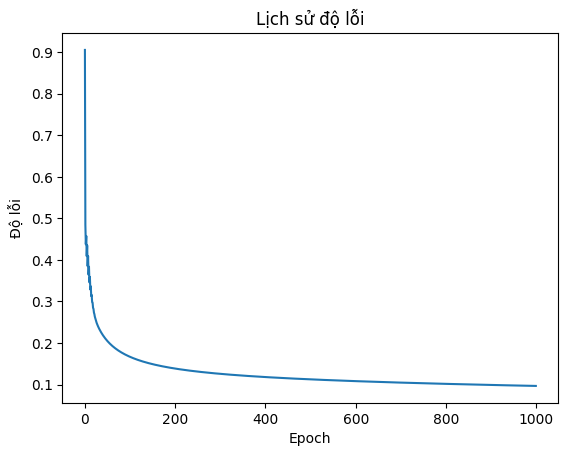

Accuracy: 0.9824561403508771
Recall: 0.9
Precision: 1.0
F1-score: 0.9473684210526316


In [16]:
data = pd.read_csv('data.csv')
x = data.loc[:,['IoU','x0','y0','w0','h0','xb','yb','wb','hb']].values
x_max = x.max(axis = 0, keepdims = True)
x_min = x.min(axis = 0, keepdims = True)
def scaled(x,x_max,x_min):
    x_scaled = (x-x_min)/(x_max-x_min)
    x_scaled = np.hstack((np.ones((x_scaled.shape[0],1)),x_scaled))
    return x_scaled
x_scaled = scaled(x,x_max,x_min)
w = np.zeros((x_scaled.shape[1],1))
y_scaled = data.loc[:,['select']].values


#train
g = lambda z :np.exp(z) / (1+np.exp(z))
def predict(x,w):
    # print(x.shape,w.shape)
    z = np.dot(x,w)
    return g(z)

def predict_(x,w):
    y_pre = predict(x,w)
    y_pre[y_pre >= 0.5] = 1
    y_pre[y_pre < 0.5] = 0
    return y_pre
#Hàm Loss
def loss(x,y,w):
    y_pred = predict(x,w)
    dy = y*np.log(y_pred+1e-12)+(1-y)*np.log(1-y_pred+1e-12)
    return -np.mean(dy,axis=0,keepdims= False)

def gradient(x,y,w):
    y_pred = predict(x,w)
    dy = y_pred-y
    dw = np.dot(x.T,dy)
    return dw

def gradDescent(x,y,w,lr=0.1,epochs=1000):
    history = []
    for i in range(epochs):
        dw = gradient(x,y,w)
        w = w-lr*dw
        l = loss(x,y,w)
        history.append(l)
    return history,w

history,bw = gradDescent(x_scaled,y_scaled,w,lr=0.2,epochs=1000)
plt.plot(history)
plt.title('Lịch sử độ lỗi')
plt.xlabel('Epoch')
plt.ylabel('Độ lỗi')
plt.show()

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
# Dữ liệu dự đoán và nhãn thực tế
y_pred = predict_(x_scaled,bw)
y_true = y_scaled

# Tính toán accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Tính toán recall
recall = recall_score(y_true, y_pred)
print("Recall:", recall)

# Tính toán precision
precision = precision_score(y_true, y_pred)
print("Precision:", precision)

# Tính toán F1-score
f1 = f1_score(y_true, y_pred)
print("F1-score:", f1)

# lưu model ma tran bw
matrix = bw
# Chuyển đổi ma trận thành một danh sách lồng nhau
matrix_list = matrix.tolist()

# Lưu danh sách ma trận thành mô hình JSON
with open('LPD', 'w') as f:
    json.dump(matrix_list, f)



In [17]:
def detect(img):
    # Tải lại mô hình
    with open('LPD', 'r') as f:
        loaded_matrix_list = json.load(f)
    # Chuyển đổi danh sách thành ma trận numpy
    LPD = np.array(loaded_matrix_list)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, gray = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Tìm ra diện tích của toàn bộ các contours
    area_cnt = [cv2.contourArea(cnt) for cnt in contours]
    area_sort = np.argsort(area_cnt)[::-1]
    # Top 5 contour có diện tích lớn nhất
    area_sort[:5]
    listdata = [['IoU','x0','y0','w0','h0','xb','yb','wb','hb']]
    listdata.clear()
    idex = 0
    for i in range(7):
        IoU = area_cnt[area_sort[0]]/area_cnt[area_sort[i]]
        cnt0 = contours[area_sort[0]]
        x0,y0,w0,h0 = cv2.boundingRect(cnt0)
        cntb = contours[area_sort[i]]
        xb,yb,wb,hb = cv2.boundingRect(cntb)       
        list = [IoU,x0,y0,w0,h0,xb,yb,wb,hb]
        list = np.array(list)
        list_scaled = scaled(list,x_max,x_min)
        if(predict_(list_scaled,LPD)==1):
            idex = i
        cnt = contours[area_sort[i]]
        x,y,w,h = cv2.boundingRect(cnt)
        print('centroid: ({}, {}), (width, height): ({}, {})'.format(x, y, w, h))
        img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        plt.imshow(img)
    return img

centroid: (0, 176), (width, height): (1536, 1522)
centroid: (20, 1297), (width, height): (1341, 279)
centroid: (331, 1308), (width, height): (686, 163)
centroid: (0, 1936), (width, height): (1338, 112)
centroid: (133, 936), (width, height): (1087, 279)
centroid: (1238, 752), (width, height): (298, 303)
centroid: (688, 403), (width, height): (458, 107)


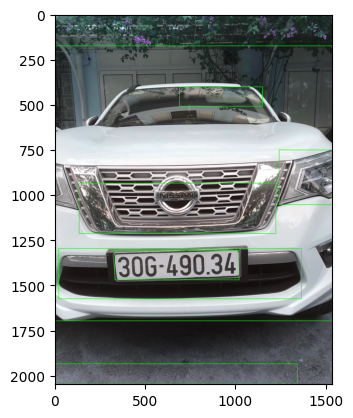

In [18]:
img = cv2.imread('t.jpg')
img = detect(img)
plt.imshow(img)